In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# from torchmetrics.classification import Accuracy  # You can also implement accuracy manually if not using torchmetrics

### 加载数据

In [2]:
def load_data(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            label, sentence = line.strip().lower().split('\t', maxsplit=1)
            data.append((sentence, label))
    return data

train_dataset = load_data('../dataset/train.txt')
dev_dataset = load_data('../dataset/dev.txt')
test_dataset = load_data('../dataset/test.txt')

dev_dataset[0]

("just watched conrack for the first time. although the last third of the movie leaves something to be desired, it is a very touching and heartwarming study of a man's evolution to overcome his youth and upbringing in a prejudiced south and a teacher's creativity in connecting with students despite different backgrounds and difficult circumstances. as an educator, seeing a teacher adapt to his students and prepare them for all of the challenges life has to offer, not just the lessons found in textbooks, is a valuable concept of which we all need to be reminded. the thread concerning the vietnam war rings true even today. well worth a look.",
 '1')

In [3]:
# 将词表加载到内存
def load_dict(path):
    assert os.path.exists(path)
    words = []
    with open(path, 'r', encoding='utf-8') as f:
        words = f.readlines()
        words = [word.strip() for word in words if word.strip()]  # 去除空串
    word2id = dict(zip(words, range(len(words))))
    return word2id

from itertools import islice
word2id = load_dict('../dataset/vocab.txt')
dict(islice(word2id.items(), 20))

{'[PAD]': 0,
 '[UNK]': 1,
 'the': 2,
 'a': 3,
 'and': 4,
 'of': 5,
 'to': 6,
 'is': 7,
 'in': 8,
 'i': 9,
 'this': 10,
 'that': 11,
 'it': 12,
 '/><br': 13,
 'was': 14,
 'as': 15,
 'for': 16,
 'with': 17,
 'but': 18,
 'on': 19}

In [4]:
class IMDBDataset(Dataset):
    def __init__(self, data, word2id) -> None:
        super().__init__()
        self.word2id = word2id
        self.data = self.convert_tokens_to_ids(data)
    
    def convert_tokens_to_ids(self, data):
        tmp_data = []
        for i, dt in enumerate(data):
            sent, id = dt
            sent = [self.word2id.get(word, self.word2id['[UNK]']) for word in sent.split(' ')]
            id = int(id)
            tmp_data.append([sent, id])
        return tmp_data

    def __getitem__(self, index):
        sent, id = self.data[index]
        return sent, id
        # return torch.tensor(sent, dtype=torch.long), torch.tensor(id, dtype=torch.long)

    def __len__(self):
        return len(self.data)
    
# 实例化Dataset
train_set = IMDBDataset(train_dataset, word2id)
dev_set = IMDBDataset(dev_dataset, word2id)
test_set = IMDBDataset(test_dataset, word2id)

len(train_set), len(dev_set), len(test_set)

(25000, 12500, 12500)

### 构造DataLoader

在训练模型时，通常将数据分批传入模型进行训练，每批数据作为一个`mini-batch`传入模型进行计算处理.

观察每批数据的特点会发现，一个`mini-batch`中通常包含若干条文本，但每条文本的长度不一致，会给模型训练带来困难。通常的做法是使用文本截断和文本填充两种方式，将每个minibatch中的数据统一成固定的长度。

- 1）文本截断：在训练过程中设置一个序列最大长度`max_seq_len`，对过长的文本进行截断，避免由于数据过长影响整体的模型训练效果。
- 2）文本填充：统计该批数据的文本序列的最大长度`max_len`，当文本序列的长度小于`max_len`时，使用`[PAD]`进行填充，将该文本序列补齐到`max_len`的长度。

<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/c02b1c30126f464c9cdcc576f12b9066129716b6badf40e0b4cc4b7b93f19dab" width=80%></center>
<br></br>

In [13]:
from functools import partial

def collate_fn(batch_data, pad_val=0, max_length=256):
    sents, sent_len, labels = [], [], []
    max_len = 0
    for data in batch_data:
        sent, label = data
        # Truncate the sequence
        sent = sent[:max_length]

        # Store the truncated sequences, lengths, and labels
        sent_len.append(len(sent))
        labels.append(label)

        # Track the maximum sequence length
        max_len = max(max_len, len(sent))
        sents.append(sent)
    
    # Padding
    padding_sents = []
    for sent in sents:
        sent_tensor = torch.tensor(sent, dtype=torch.long)  # Convert list to tensor
        pad_size = max_len - len(sent)
        padded_sent = F.pad(sent_tensor, (0, pad_size), value=pad_val)
        padding_sents.append(padded_sent)

    sents_tensor = torch.stack(padding_sents)
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    sent_len_tensor = torch.tensor(sent_len, dtype=torch.long)

    return sents_tensor, labels_tensor, sent_len_tensor

max_sents_length = 256
batch_size = 128
collate_fn = partial(collate_fn, pad_val=word2id['[PAD]'], max_length=max_sents_length)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=False, collate_fn=collate_fn)
dev_loader = DataLoader(dev_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, collate_fn=collate_fn)


### 模型构建

LSTM根据 时序关系 依次处理每次输入的`minibatch`数据。

先将一条文本序列中的所有单词传入 LSTM 模型，LSTM 模型输出的隐状态可以被看作是融合了之前所有单词的状态向量，因此这个状态变量也可以看作是这条文本序列的语义向量表示。然后，将该语义向量传入到线性层（将隐层向量乘以权重，再加上偏置），经过`Softmax`处理后便可得到文本属于情感类别（积极或消极）的概率，如图所示。


<br></br>
<center><img src="https://ai-studio-static-online.cdn.bcebos.com/038ed1841af849aab3b8803f41d6237827f5ed4cdf4f4cc4b858d727d6f28c50" width=80%></center>
<br></br>

In [6]:
class SentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_embed, num_classes=2, num_layers=1, init_scale=0.1, dropout_rate=None) -> None:
        super().__init__()
        self.input_size = input_size      # 输入词向量维度
        self.hidden_size = hidden_size    # LSTM的状态向量维度
        self.num_embed = num_embed        # 词向量个数 即词表大小
        self.num_classes = num_classes    # 情感分类个数 pos, neg
        self.num_layers = num_layers      # 网络层数
        self.init_scale = init_scale      # dropout rate
        self.dropout_rate = dropout_rate  # 网络内部的参数的初始化范围

        # embedding layer to convert words in sentences to vector
        self.embedding = nn.Embedding(num_embeddings=num_embed, embedding_dim=input_size, padding_idx=0)
        # dropout layer for regularisation
        self.dropout_layer = nn.Dropout(p=self.dropout_rate) if self.dropout_rate is not None else None
        # LSTM layer
        self.lstm_layer = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        # Fully Connected Layer for classification
        self.cls_layer = nn.Linear(self.hidden_size, self.num_classes)

        # init weights
        self.init_weights()

    def init_weights(self):
        # init embedding weights
        nn.init.uniform_(self.embedding.weight, -self.init_scale, self.init_scale)

        # init LSTM weights
        for name, param in self.lstm_layer.named_parameters():
            if 'weight' in name:
                nn.init.uniform_(param, -self.init_scale, self.init_scale)
            elif 'bias' in name:
                nn.init.constant_(param, 0)

        # init linear layer weights
        nn.init.uniform_(self.cls_layer.weight, -self.init_scale, self.init_scale)
        nn.init.constant_(self.cls_layer.bias, 0)
    
    def forward(self, inputs, sent_lens=None):
        inputs_emb = self.embedding(inputs)

        # apply dropout if specified
        if self.dropout_rate is not None:
            inputs_emb = self.dropout_layer(inputs_emb)
        
        packed_output, (hidden_states, cell_states) = self.lstm_layer(inputs_emb)

        # extract last hidden states
        hidden_states = hidden_states[-1]
        logits = self.cls_layer(hidden_states)

        return logits

In [7]:
class AccuracyMetric:
    def __init__(self):
        self.correct = 0
        self.total = 0

    def reset(self):
        self.correct = 0
        self.total = 0

    def compute(self, preds, labels):
        # Reuse compute_accuracy function to get the number of correct predictions
        _, predicted = torch.max(preds, dim=1)
        correct = (predicted == labels).sum().item()
        return correct

    def update(self, correct):
        self.correct += correct
        self.total += 1  # Assuming each `correct` update is for a batch of size 1
    
    def accumulate(self):
        return self.correct / self.total if self.total > 0 else 0


In [24]:
num_epoches = 50
learning_rate = 0.0001
eval_steps = 50
log_steps = 10
save_dir = '../checkpoints/lstm_checkpoints'

input_size = 256
hidden_size = 256
num_embed = len(word2id)
num_layers  = 1
dropout_rate = 0.2
num_classes = 2

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = SentimentClassifier(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_embed=num_embed, 
    num_classes=num_classes,
    num_layers=num_layers, 
    dropout_rate=dropout_rate
).to(device)

optimizer = optim.Adam(lr=learning_rate, params=model.parameters())
criterion = nn.CrossEntropyLoss()
metric = AccuracyMetric()

### 模型训练

In [25]:
def evaluate(model, data_loader, metric):
    model.eval()
    metric.reset()

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for batch_id, data in enumerate(data_loader):
            inputs, labels, sent_lens = data
            
            # to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            sent_lens = sent_lens.to(device)

            # calculate model outpout
            logits = model(inputs, sent_lens)

            # Accumulate evaluation metrics
            correct = metric.compute(logits, labels)
            metric.update(correct)
    
    dev_score = metric.accumulate()
    return dev_score

In [26]:
def train(model):
    model.train()
    global_step = 0.0
    best_score = 0.0
    # records for training losses and evaluation scores
    train_loss_records = []
    train_score_records = []
    num_training_steps = len(train_loader) * num_epoches

    # training loop
    for epoch in range(num_epoches):
        for step, data in enumerate(train_loader):
            inputs, labels, sent_lens = data

            # to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            sent_lens = sent_lens.to(device)

            # compute logits(output)
            logits = model(inputs, sent_lens)
            
            # compute loss
            loss = criterion(logits, labels)
            train_loss_records.append((global_step, loss.item()))

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if global_step % log_steps == 0:
                print(f"[Train] epoch: {epoch}/{num_epoches}, step: {global_step}/{num_training_steps}, loss: {loss.item():.5f}")

            if global_step != 0 and (global_step % eval_steps == 0 or global_step == (num_training_steps - 1)):
                dev_score = evaluate(model, dev_loader, metric)
                train_score_records.append((global_step, dev_score))

                model.train()  # Switch back to training mode

                # save the best model
                if dev_score > best_score:
                    print(f"[Evaluate] best accuracy performance has been updated: {best_score:.5f} --> {dev_score:.5f}")
                    best_score = dev_score
                    save_path = os.path.join(save_dir, "best.pth")
                    torch.save(model.state_dict(), save_path)
                
                print(f"[Evaluate]  dev score: {dev_score:.5f}")
            global_step += 1

    save_path = os.path.join(save_dir, 'final.pth')
    torch.save(model.state_dict(), save_path)
    print("[Train] Training end.")

    return train_loss_records, train_score_records

In [27]:
print(torch.backends.mps.is_available())

True


In [28]:
train_loss_record, train_score_record = train(model)

[Train] epoch: 0/50, step: 0.0/9800, loss: 0.69360
[Train] epoch: 0/50, step: 10.0/9800, loss: 0.69656
[Train] epoch: 0/50, step: 20.0/9800, loss: 0.69110
[Train] epoch: 0/50, step: 30.0/9800, loss: 0.69231
[Train] epoch: 0/50, step: 40.0/9800, loss: 0.69251
[Train] epoch: 0/50, step: 50.0/9800, loss: 0.69337
[Evaluate] best accuracy performance has been updated: 0.00000 --> 64.27551
[Evaluate]  dev score: 64.27551
[Train] epoch: 0/50, step: 60.0/9800, loss: 0.69148
[Train] epoch: 0/50, step: 70.0/9800, loss: 0.68999
[Train] epoch: 0/50, step: 80.0/9800, loss: 0.69331
[Train] epoch: 0/50, step: 90.0/9800, loss: 0.69324
[Train] epoch: 0/50, step: 100.0/9800, loss: 0.69189
[Evaluate]  dev score: 63.37755
[Train] epoch: 0/50, step: 110.0/9800, loss: 0.69340
[Train] epoch: 0/50, step: 120.0/9800, loss: 0.69118
[Train] epoch: 0/50, step: 130.0/9800, loss: 0.69466
[Train] epoch: 0/50, step: 140.0/9800, loss: 0.69576
[Train] epoch: 0/50, step: 150.0/9800, loss: 0.69855
[Evaluate] best accurac

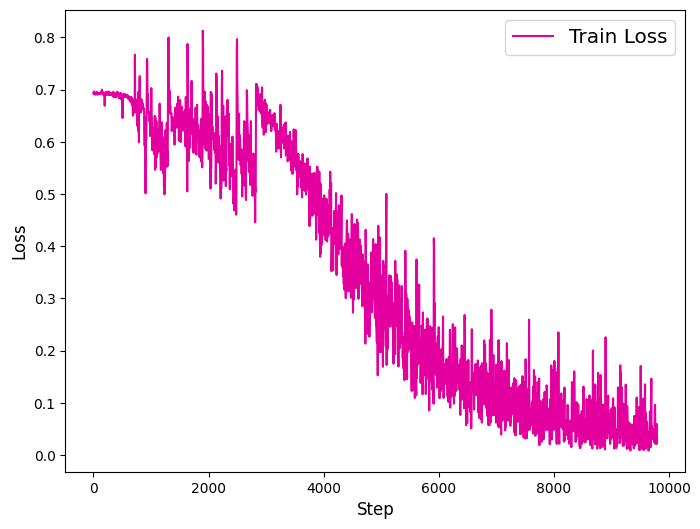

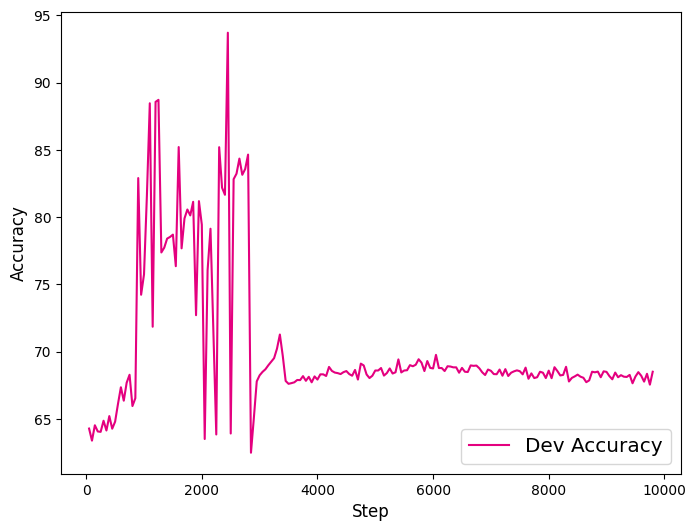

In [30]:
import matplotlib.pyplot as plt

def plot_training_loss(train_loss_record, fig_size=(8, 6), sample_step=10, loss_legend_loc='lower left', acc_legend_loc='lower left'):
    plt.figure(figsize=fig_size)

    train_steps = [x[0] for x in train_loss_record][::sample_step]
    train_losses = [x[1] for x in train_loss_record][::sample_step]

    plt.plot(train_steps, train_losses, color='#e4009f', label='Train Loss')
    plt.ylabel("Loss", fontsize='large')
    plt.xlabel("Step", fontsize='large')
    plt.legend(loc=loss_legend_loc, fontsize='x-large')

    # plt.savefig(fig_name)
    plt.show()

def plot_training_acc(train_score_record, fig_size=(8, 6), sample_step=10, loss_legend_loc="lower left", acc_legend_loc="lower left"):
    plt.figure(figsize=fig_size)

    train_steps=[x[0] for x in train_score_record]
    train_losses = [x[1] for x in train_score_record]

    plt.plot(train_steps, train_losses, color='#e4007f', label="Dev Accuracy")
    #绘制坐标轴和图例
    plt.ylabel("Accuracy", fontsize='large')
    plt.xlabel("Step", fontsize='large')
    plt.legend(loc=loss_legend_loc, fontsize='x-large')

    # plt.savefig(fig_name)
    plt.show()


# fig_path = "./images/chapter9_loss.pdf"
plot_training_loss(train_loss_record, loss_legend_loc="upper right", sample_step=5)

# fig_path = "./images/chapter9_acc.pdf"
plot_training_acc(train_score_record, sample_step=1, loss_legend_loc="lower right")

### 模型评估

In [31]:
saved_state = torch.load('../checkpoints/lstm_checkpoints/best.pth', map_location=device)

model = SentimentClassifier(
    input_size=input_size, 
    hidden_size=hidden_size, 
    num_embed=num_embed, 
    num_classes=num_classes, 
    num_layers=num_layers, 
    dropout_rate=dropout_rate
)

model.load_state_dict(state_dict=saved_state)

model.to(device)

model.eval()

# Evaluate the model using the test_loader
test_score = evaluate(model, test_loader, metric)
print(f"Test Accuracy: {test_score:.5f}")

/var/folders/t7/y9flkbg90kldy7693bcr6wq00000gn/T/ipykernel_60953/3062121858.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load('../checkpoints/lstm

Test Accuracy: 93.81633


### 模型推测

In [41]:
def infer(model, text):
    model.eval()
    words = [word2id.get(word, word2id['[UNK]']) for word in text.split(' ')]
    words = torch.tensor(words, dtype=torch.long).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(words, torch.tensor([len(words[0])], dtype=torch.long).to(device))

    max_label_id = torch.argmax(logits, dim=1).item()  # Get the index of the max logit
    print('Label: ', 'Positive' if max_label_id == 1 else 'Negative')
    # print('Label: ', max_label_id)


infer(model, 'good')
infer(model, 'good.')

Label:  Negative
Label:  Positive
